# Model train
---

## Import

In [22]:
import torch
from torch_geometric.datasets import Reddit, Amazon
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch.functional import F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data
import torch.optim as optim
import seaborn as sns


np.random.seed(0)

## Read, understand and prepare the data

In [2]:
node_data = pd.read_parquet('data/amazon_product_data_word2vec.parquet')

In [3]:
data = torch.load('data/amazon_product_data.pt')
data.num_classes = data.y.unique().shape[0]

/tmp/ipykernel_433170/1909746715.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data/amazon_product_data.pt')


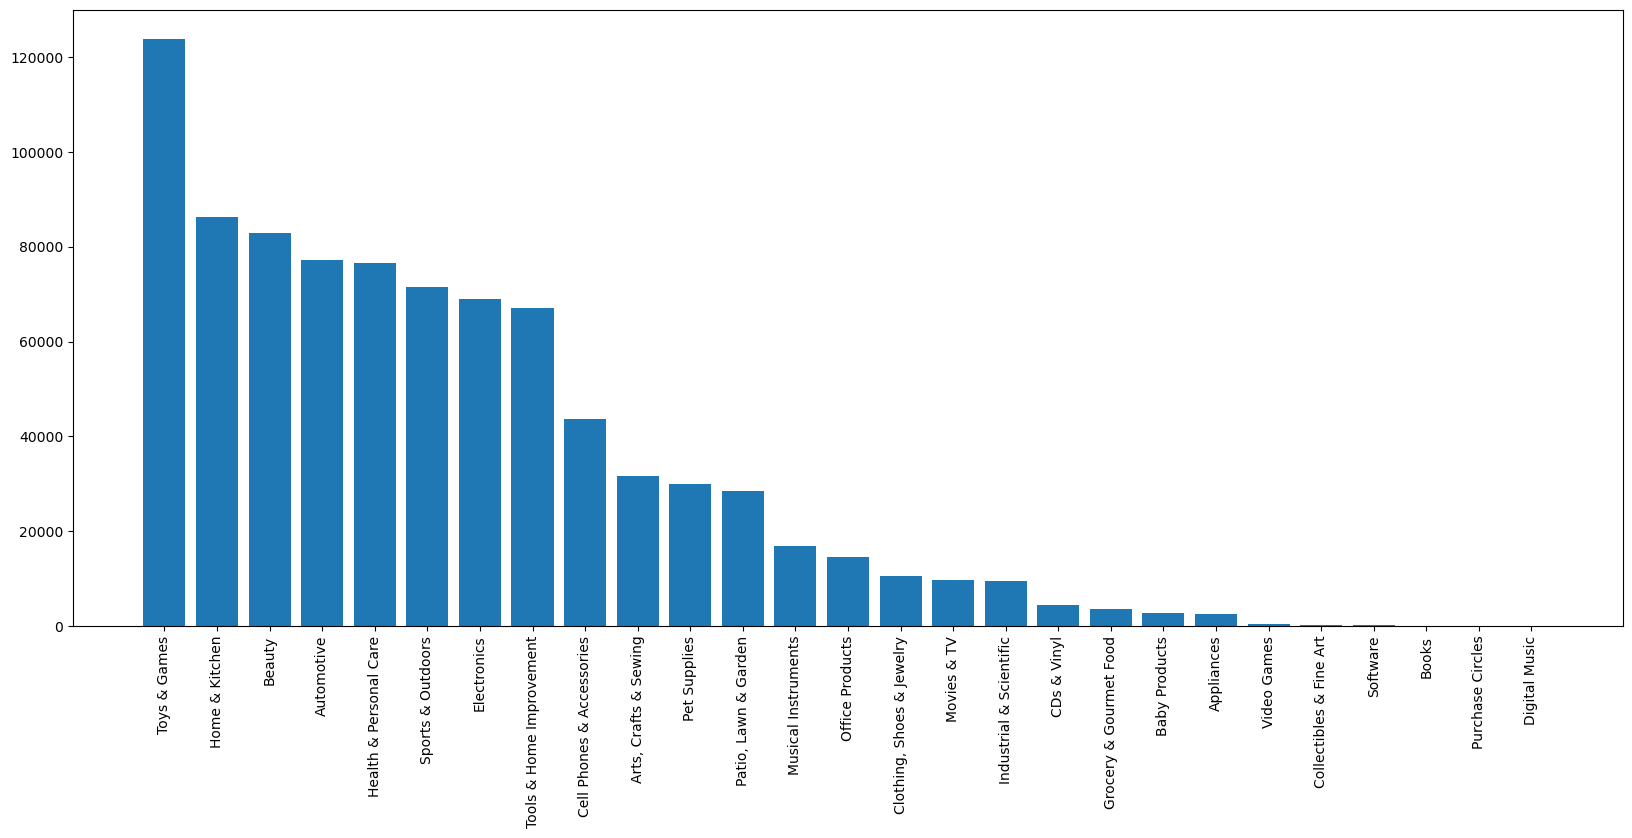

In [21]:
value_counts = node_data['main_category'].value_counts()

# plot a bar chart of the main categories
plt.figure(figsize=(20, 8))
plt.bar(value_counts.index, value_counts.values)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [5]:
print("data", data)
print("num nodes", data.num_nodes)
print("Num edges", data.num_edges)
print("num node features", data.num_node_features)
print("is undirected", data.is_undirected())
print("is directed", data.is_directed())
print("num edge features", data.num_edge_features)
print('num classes', data.num_classes)

data Data(x=[863130, 100], edge_index=[2, 815222], y=[863130], num_classes=27)
num nodes 863130
Num edges 815222
num node features 100
is undirected False
is directed True
num edge features 0
num classes 27


In [6]:
# def create_data_split_masks(data, train_ratio=0.8, val_ratio=0.1):
#   # Total number of nodes
#   num_nodes = data.num_nodes

#   # Randomly permute the node indices
#   perm = torch.randperm(num_nodes)

#   # Calculate split sizes
#   train_size = int(train_ratio * num_nodes)
#   val_size = int(val_ratio * num_nodes)
#   test_size = num_nodes - train_size - val_size

#   # Create masks for train, validation, and test
#   train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#   val_mask = torch.zeros(num_nodes, dtype=torch.bool)
#   test_mask = torch.zeros(num_nodes, dtype=torch.bool)

#   # Assign masks
#   train_mask[perm[:train_size]] = True
#   val_mask[perm[train_size:train_size + val_size]] = True
#   test_mask[perm[train_size + val_size:]] = True

#   # Assign masks to the data object
#   data.train_mask = train_mask
#   data.val_mask = val_mask
#   data.test_mask = test_mask
  
#   return data
    

In [23]:
import random


def create_masks(data, num_nodes, train_ratio, val_ratio):
    # Generate and shuffle indices
    indices = list(range(num_nodes))
    # shuflle with numpy rng to get reproducibility
    np.random.shuffle(indices)
    
    # Create masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Set proportions for train, val, and test
    train_end = int(train_ratio * num_nodes)
    val_end = train_end + int(val_ratio * num_nodes)

    train_mask[indices[:train_end]] = True
    val_mask[indices[train_end:val_end]] = True
    test_mask[indices[val_end:]] = True

    # Assign the custom masks to the dataset
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask


def train_test_split_graph(data, train_ratio, val_ratio):
    num_nodes = data.num_nodes

    # Call the function to create masks
    create_masks(data, num_nodes, train_ratio, val_ratio)

    # Step 5: Create train, validation, and test node indices based on the masks
    train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
    val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
    test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)

    # create the data loaders
    train_loader = NeighborLoader(data,
      # Sample 30 neighbors for each node for 2 iterations
      num_neighbors=[30] * 2,
      batch_size=128,
      input_nodes=train_idx,
    )
    val_loader = NeighborLoader(data,
      num_neighbors=[30] * 2,
      batch_size=128,
      input_nodes=val_idx,
    )
    test_loader = NeighborLoader(data,
      num_neighbors=[30] * 2,
      batch_size=128,
      input_nodes=test_idx,
    )

    return train_loader, val_loader, test_loader

## Model training

In [24]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        x = self.linear1(h)
        x = F.relu(x)
        x = self.linear2(x)

        return F.log_softmax(x, dim=1)


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.linear1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        x = self.linear1(h)
        x = F.relu(x)
        x = self.linear2(x)

        return F.log_softmax(x, dim=1)

In [25]:
# def train_epoch(model, optimizer, loader, device):
#     """Train the model for one epoch"""
#     model.train()
    
#     b_losses = np.empty(len(loader))
#     b_accuracies = np.empty(len(loader))

#     for batch in loader:
#       batch.to(device)
#       optimizer.zero_grad()
#       out = model(batch.x, batch.edge_index)
#       loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])
#       loss.backward()
#       optimizer.step()
      
#       b_losses = np.append(b_losses, loss.item())
      
#       b_acc = (out[batch.train_mask].argmax(dim=1) == batch.y[batch.train_mask]).sum().item() / batch.train_mask.sum().item()
#       b_accuracies = np.append(b_accuracies, b_acc)
      
#     loss = np.mean(b_losses)
#     acc = np.mean(b_accuracies)
#     return loss, acc


# @torch.no_grad()
# def evaluate(model, loader, mask_name, device):
#     model.eval()
#     correct = 0
    
#     for batch in loader:
#         batch.to(device)
#         out = model(batch.x, batch.edge_index)
#         pred = out.argmax(dim=1)
#         mask = getattr(batch, mask_name)
#         correct += pred[mask].eq(batch.y[mask]).sum().item()
        
#     total = sum(getattr(batch, mask_name).sum().item() for batch in loader)
#     return correct / total

In [39]:
def train_epoch(model, optimizer, loader, device):
    """Train the model for one epoch using NeighborSampler mini-batches."""
    model.train()
    b_losses = np.empty(len(loader))
    b_accuracies = np.empty(len(loader))

    for batch in loader:
      optimizer.zero_grad()
      batch.to(device)
      
      out = model(batch.x, batch.edge_index).to(device)
      loss = F.nll_loss(out, batch.y)
      
      # Backpropagation
      loss.backward()
      optimizer.step()
      
      b_losses = np.append(b_losses, loss.item())
      b_acc = (out.argmax(dim=1) == batch.y).sum().item() / batch.y.size(0)
      b_accuracies = np.append(b_accuracies, b_acc)
        
    return np.mean(b_losses), np.mean(b_accuracies)


@torch.no_grad()
def evaluate(model, data_loader, device, data):
    """Evaluate the model on the validation or test set using NeighborSampler mini-batches."""
    model.eval()
    total_correct = 0

    for batch_size, n_id, adjs in data_loader:
        adjs = [adj.to(device) for adj in adjs]

        # Compute predictions for all nodes in the mini-batch
        x_input = data.x[n_id].to(device)
        out = model(x_input, adjs[0].edge_index)

        # Get predictions only for the first `batch_size` target nodes
        pred = out[:batch_size].max(dim=1)[1]

        # Compare with the actual labels of the target nodes
        total_correct += (pred ==
                          data.y[n_id[:batch_size]].to(device)).sum().item()

    # Calculate accuracy based on the number of target nodes in the entire set
    return total_correct / len(data_loader.dataset)
  
# compute confusion matrix
def confusion_matrixx(model, loader, device, data):
    model.eval()
    y_true = []
    y_pred = []

    for batch_size, n_id, adjs in loader:
        adjs = [adj.to(device) for adj in adjs]
        x_input = data.x[n_id].to(device)
        out = model(x_input, adjs[0].edge_index)
        pred = out[:batch_size].max(dim=1)[1]

        y_true.append(data.y[n_id[:batch_size]].to(device))
        y_pred.append(pred)

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)

    return y_true, y_pred

## Main

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_ratio = 0.8
val_ratio = 0.1


train_loader, val_loader, _ = train_test_split_graph(data, train_ratio, val_ratio)

# Initialize the model and optimizer
model = GAT(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1, 4):
    loss, acc = train_epoch(model, optimizer, train_loader, device)
    # val_acc = evaluate(model, val_loader, device, data)
    # print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train Acc: {acc:.4f}')

[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 9.97338023e-313
 6.75643460e-310 3.31550598e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 6.75643460e-310
 3.31550598e+000 3.28833127e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 3.31550598e+000
 3.28833127e+000 3.26630425e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 3.28833127e+000
 3.26630425e+000 3.23537946e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 3.26630425e+000
 3.23537946e+000 3.13938069e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 3.23537946e+000
 3.13938069e+000 3.02045560e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 3.13938069e+000
 3.02045560e+000 2.93818831e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 3.02045560e+000
 2.93818831e+000 2.85404491e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 2.93818831e+000
 2.85404491e+000 3.04117012e+000]
[6.75664328e-310 4.89219469e-310 4.89220342e-310 ... 2.85404491e+000
 3.0

KeyboardInterrupt: 

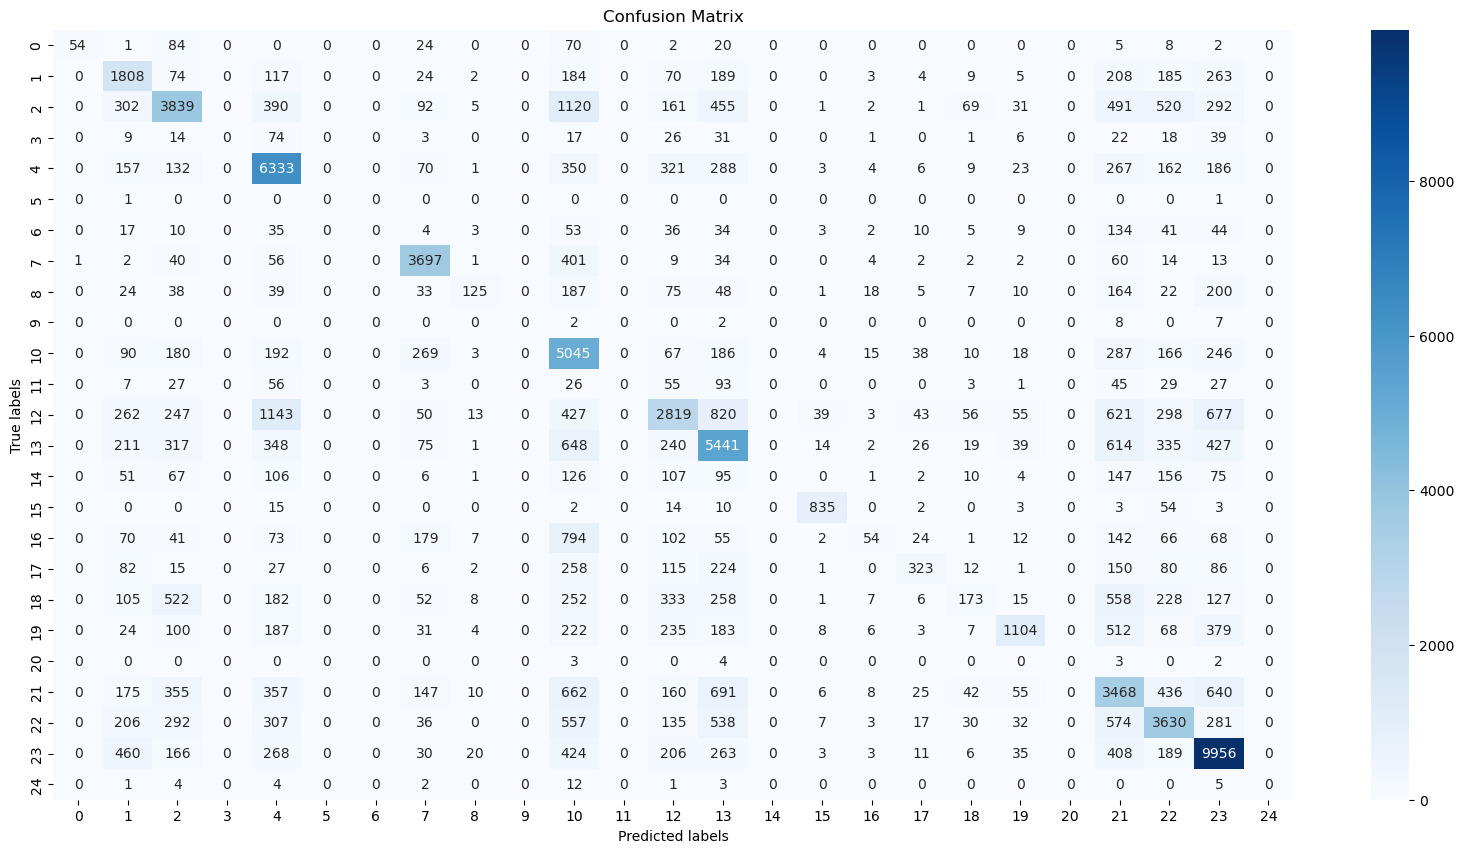

In [19]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true, y_pred = confusion_matrixx(model, val_loader, device, data)
cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()